In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from cityseer.metrics import networks
from cityseer.tools import graphs, io

streets_gpd = gpd.read_file("data/madrid_streets/street_network.gpkg")
streets_gpd = streets_gpd.explode(reset_index=True)
G = io.nx_from_generic_geopandas(streets_gpd)
G_dual = graphs.nx_to_dual(G)

INFO:cityseer.tools.graphs:Merging parallel edges within buffer of 1.
INFO:cityseer.tools.graphs:Converting graph to dual.
INFO:cityseer.tools.graphs:Preparing dual nodes
INFO:cityseer.tools.graphs:Preparing dual edges (splitting and welding geoms)


In [2]:
# prepare the data structures
nodes_gdf, edges_gdf, network_structure = io.network_structure_from_nx(G_dual)

INFO:cityseer.tools.io:Preparing node and edge arrays from networkX graph.
INFO:cityseer.graph:Edge R-tree built successfully with 104026 items.


In [3]:
distances = [500, 2000, 5000]
nodes_gdf = networks.node_centrality_shortest(
    network_structure=network_structure,
    nodes_gdf=nodes_gdf,
    distances=distances,
)
for col in nodes_gdf.columns:
    if col.startswith("cc_"):
        nodes_gdf[f"{col}_not"] = nodes_gdf[col]

INFO:cityseer.metrics.networks:Computing shortest path node centrality.
INFO:cityseer.config:Metrics computed for:
INFO:cityseer.config:Distance: 500m, Beta: 0.008, Walking Time: 6.25 minutes.
INFO:cityseer.config:Distance: 2000m, Beta: 0.002, Walking Time: 25.0 minutes.
INFO:cityseer.config:Distance: 5000m, Beta: 0.0008, Walking Time: 62.5 minutes.


In [4]:
network_structure, stops, avg_stop_pairs = io.add_transport_gtfs(
    "data/madrid_gtfs/madrid_metro",
    network_structure,
    nodes_gdf.crs,
)


INFO:cityseer.tools.io:Loading GTFS data from data/madrid_gtfs/madrid_metro
INFO:cityseer.tools.io:Loaded 1272 stops and 2360 stop times
INFO:cityseer.tools.io:Adding GTFS stops to network nodes (with street linking logic).
INFO:cityseer.tools.io:Generating segment durations between stops.
INFO:cityseer.tools.io:Adding GTFS segments to network edges.
INFO:cityseer.graph:Edge R-tree built successfully with 104026 items.


In [5]:
stops

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding,avg_wait_time
0,gtfs-data/madrid_gtfs/madrid_metro-par_4_1,1,PLAZA DE CASTILLA,Paseo de la Castellana 189,40.46690,-3.68917,A,http://www.crtm.es,0,est_90_21,NaN,0,430.357143
1,gtfs-data/madrid_gtfs/madrid_metro-acc_4_1_1,1,Plaza de Castilla,Paseo de la Castellana 189,40.46682,-3.68918,NaN,http://www.crtm.es,2,est_90_21,NaN,0,NaN
2,gtfs-data/madrid_gtfs/madrid_metro-acc_4_1_1040,1,Ascensor,Plaza de Castilla 9,40.46555,-3.68877,NaN,http://www.crtm.es,2,est_90_21,NaN,0,NaN
3,gtfs-data/madrid_gtfs/madrid_metro-acc_4_1_1043,1,Intercambiador Superficie,Paseo de la Castellana 191 B,40.46728,-3.68915,NaN,http://www.crtm.es,2,est_90_21,NaN,0,NaN
4,gtfs-data/madrid_gtfs/madrid_metro-acc_4_1_1044,1,Ascensor,Paseo de la Castellana 189,40.46702,-3.68918,NaN,http://www.crtm.es,2,est_90_21,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267,gtfs-data/madrid_gtfs/madrid_metro-est_4_234,234,HOSPITAL SEVERO OCHOA,Avda Orellana 3,40.32177,-3.76797,B1,http://www.crtm.es,1,NaN,Europe/Madrid,2,NaN
1268,gtfs-data/madrid_gtfs/madrid_metro-est_4_235,235,LEGANES CENTRAL,Calle Virgen del Camino 1,40.32899,-3.77154,B1,http://www.crtm.es,1,NaN,Europe/Madrid,2,NaN
1269,gtfs-data/madrid_gtfs/madrid_metro-est_4_236,236,SAN NICASIO,Avda Mar Mediterráneo SN,40.33616,-3.77587,B1,http://www.crtm.es,1,NaN,Europe/Madrid,2,NaN
1270,gtfs-data/madrid_gtfs/madrid_metro-par_4_237,237,OPERA,Plaza de Isabel II 9,40.41809,-3.70928,A,http://www.crtm.es,0,est_4_36,NaN,0,13.214286


In [6]:
# convert stops to geopandas
stops_gdf = gpd.GeoDataFrame(
    stops,
    geometry=gpd.points_from_xy(stops["stop_lon"], stops["stop_lat"]),
    crs=4326,  # Adjust the CRS to suit your data if needed
)
stops_gdf = stops_gdf.to_crs(streets_gpd.crs.to_epsg())
stops_gdf

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding,avg_wait_time,geometry
0,gtfs-data/madrid_gtfs/madrid_metro-par_4_1,1,PLAZA DE CASTILLA,Paseo de la Castellana 189,40.46690,-3.68917,A,http://www.crtm.es,0,est_90_21,NaN,0,430.357143,POINT (441575.052 4479808.7)
1,gtfs-data/madrid_gtfs/madrid_metro-acc_4_1_1,1,Plaza de Castilla,Paseo de la Castellana 189,40.46682,-3.68918,NaN,http://www.crtm.es,2,est_90_21,NaN,0,NaN,POINT (441574.135 4479799.826)
2,gtfs-data/madrid_gtfs/madrid_metro-acc_4_1_1040,1,Ascensor,Plaza de Castilla 9,40.46555,-3.68877,NaN,http://www.crtm.es,2,est_90_21,NaN,0,NaN,POINT (441607.793 4479658.584)
3,gtfs-data/madrid_gtfs/madrid_metro-acc_4_1_1043,1,Intercambiador Superficie,Paseo de la Castellana 191 B,40.46728,-3.68915,NaN,http://www.crtm.es,2,est_90_21,NaN,0,NaN,POINT (441577.077 4479850.867)
4,gtfs-data/madrid_gtfs/madrid_metro-acc_4_1_1044,1,Ascensor,Paseo de la Castellana 189,40.46702,-3.68918,NaN,http://www.crtm.es,2,est_90_21,NaN,0,NaN,POINT (441574.308 4479822.026)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267,gtfs-data/madrid_gtfs/madrid_metro-est_4_234,234,HOSPITAL SEVERO OCHOA,Avda Orellana 3,40.32177,-3.76797,B1,http://www.crtm.es,1,NaN,Europe/Madrid,2,NaN,POINT (434754.721 4463754.488)
1268,gtfs-data/madrid_gtfs/madrid_metro-est_4_235,235,LEGANES CENTRAL,Calle Virgen del Camino 1,40.32899,-3.77154,B1,http://www.crtm.es,1,NaN,Europe/Madrid,2,NaN,POINT (434458.401 4464558.532)
1269,gtfs-data/madrid_gtfs/madrid_metro-est_4_236,236,SAN NICASIO,Avda Mar Mediterráneo SN,40.33616,-3.77587,B1,http://www.crtm.es,1,NaN,Europe/Madrid,2,NaN,POINT (434097.544 4465357.604)
1270,gtfs-data/madrid_gtfs/madrid_metro-par_4_237,237,OPERA,Plaza de Isabel II 9,40.41809,-3.70928,A,http://www.crtm.es,0,est_4_36,NaN,0,13.214286,POINT (439826.687 4474404.289)


In [7]:
stops.avg_wait_time.describe()
# count nan
stops.avg_wait_time.isna().sum()
# impute

np.int64(982)

In [8]:
avg_stop_pairs

,prev_stop_id,next_stop_id,avg_segment_time
0,gtfs-data/madrid_gtfs/madrid_metro-par_4_1,gtfs-data/madrid_gtfs/madrid_metro-par_4_10,92.0
1,gtfs-data/madrid_gtfs/madrid_metro-par_4_10,gtfs-data/madrid_gtfs/madrid_metro-par_4_11,80.0
2,gtfs-data/madrid_gtfs/madrid_metro-par_4_100,gtfs-data/madrid_gtfs/madrid_metro-par_4_101,86.5
3,gtfs-data/madrid_gtfs/madrid_metro-par_4_101,gtfs-data/madrid_gtfs/madrid_metro-par_4_102,126.5
4,gtfs-data/madrid_gtfs/madrid_metro-par_4_102,gtfs-data/madrid_gtfs/madrid_metro-par_4_103,184.0
...,...,...,...
274,gtfs-data/madrid_gtfs/madrid_metro-par_4_94,gtfs-data/madrid_gtfs/madrid_metro-par_4_95,110.0
275,gtfs-data/madrid_gtfs/madrid_metro-par_4_95,gtfs-data/madrid_gtfs/madrid_metro-par_4_96,107.5
276,gtfs-data/madrid_gtfs/madrid_metro-par_4_96,gtfs-data/madrid_gtfs/madrid_metro-par_4_97,104.5
277,gtfs-data/madrid_gtfs/madrid_metro-par_4_97,gtfs-data/madrid_gtfs/madrid_metro-par_4_98,93.0


## Calculate centralities

The centrality methods can now be computed.


In [9]:
distances = [500, 2000, 5000]
nodes_gdf = networks.node_centrality_shortest(
    network_structure=network_structure,
    nodes_gdf=nodes_gdf,
    distances=distances,
)

INFO:cityseer.metrics.networks:Computing shortest path node centrality.
INFO:cityseer.config:Metrics computed for:
INFO:cityseer.config:Distance: 500m, Beta: 0.008, Walking Time: 6.25 minutes.
INFO:cityseer.config:Distance: 2000m, Beta: 0.002, Walking Time: 25.0 minutes.
INFO:cityseer.config:Distance: 5000m, Beta: 0.0008, Walking Time: 62.5 minutes.


In [10]:
nodes_gdf.columns

Index(['ns_node_idx', 'x', 'y', 'live', 'weight', 'primal_edge',
       'primal_edge_node_a', 'primal_edge_node_b', 'primal_edge_idx',
       'dual_node', 'cc_beta_500', 'cc_beta_2000', 'cc_beta_5000',
       'cc_cycles_500', 'cc_cycles_2000', 'cc_cycles_5000', 'cc_density_500',
       'cc_density_2000', 'cc_density_5000', 'cc_farness_500',
       'cc_farness_2000', 'cc_farness_5000', 'cc_harmonic_500',
       'cc_harmonic_2000', 'cc_harmonic_5000', 'cc_hillier_500',
       'cc_hillier_2000', 'cc_hillier_5000', 'cc_betweenness_500',
       'cc_betweenness_2000', 'cc_betweenness_5000', 'cc_betweenness_beta_500',
       'cc_betweenness_beta_2000', 'cc_betweenness_beta_5000',
       'cc_beta_500_not', 'cc_beta_2000_not', 'cc_beta_5000_not',
       'cc_cycles_500_not', 'cc_cycles_2000_not', 'cc_cycles_5000_not',
       'cc_density_500_not', 'cc_density_2000_not', 'cc_density_5000_not',
       'cc_farness_500_not', 'cc_farness_2000_not', 'cc_farness_5000_not',
       'cc_harmonic_500_not', 

## Plots

Let's plot a selection of distance thresholds for each of the computed measures.


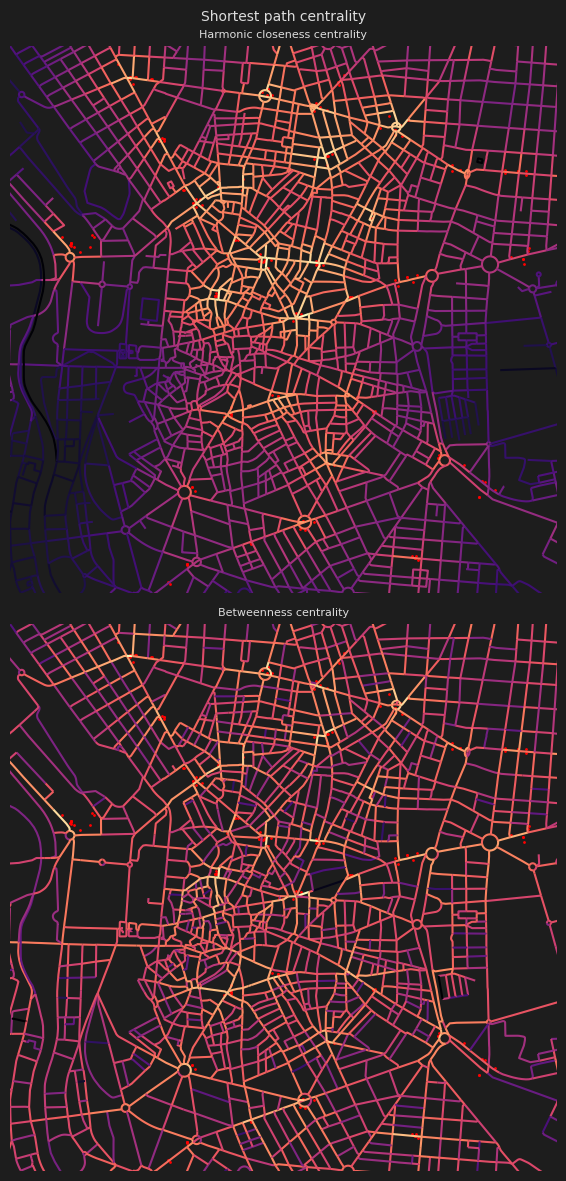

In [11]:
import matplotlib.colors as colors

fig, axes = plt.subplots(2, 1, figsize=(8, 12), facecolor="#1d1d1d")
fig.suptitle(
    "Shortest path centrality",
    fontsize=10,
    color="#ddd",
)

nodes_gdf.plot(
    column="cc_harmonic_2000",
    cmap="magma",
    legend=False,
    ax=axes[0],
)
axes[0].set_title(
    "Harmonic closeness centrality",
    fontsize=8,
    color="#ddd",
)
stops_gdf.plot(ax=axes[0], color="red", markersize=1)

nodes_gdf.plot(
    column="cc_betweenness_2000",
    cmap="magma",
    norm=colors.LogNorm(),  # Apply log normalization
    legend=False,
    ax=axes[1],
)
axes[1].set_title(
    "Betweenness centrality",
    fontsize=8,
    color="#ddd",
)
stops_gdf.plot(ax=axes[1], color="red", markersize=1)

for ax in axes:
    ax.set_xlim(438500, 438500 + 3500)
    ax.set_ylim(4472500, 4472500 + 3500)
    ax.axis(False)

plt.tight_layout()

In [12]:
nodes_gdf["cc_harmonic_2000_diff"] = (
    nodes_gdf["cc_harmonic_2000"] - nodes_gdf["cc_harmonic_2000_not"]
)
nodes_gdf["cc_betweenness_2000_diff"] = (
    nodes_gdf["cc_betweenness_2000"] - nodes_gdf["cc_betweenness_2000_not"]
)

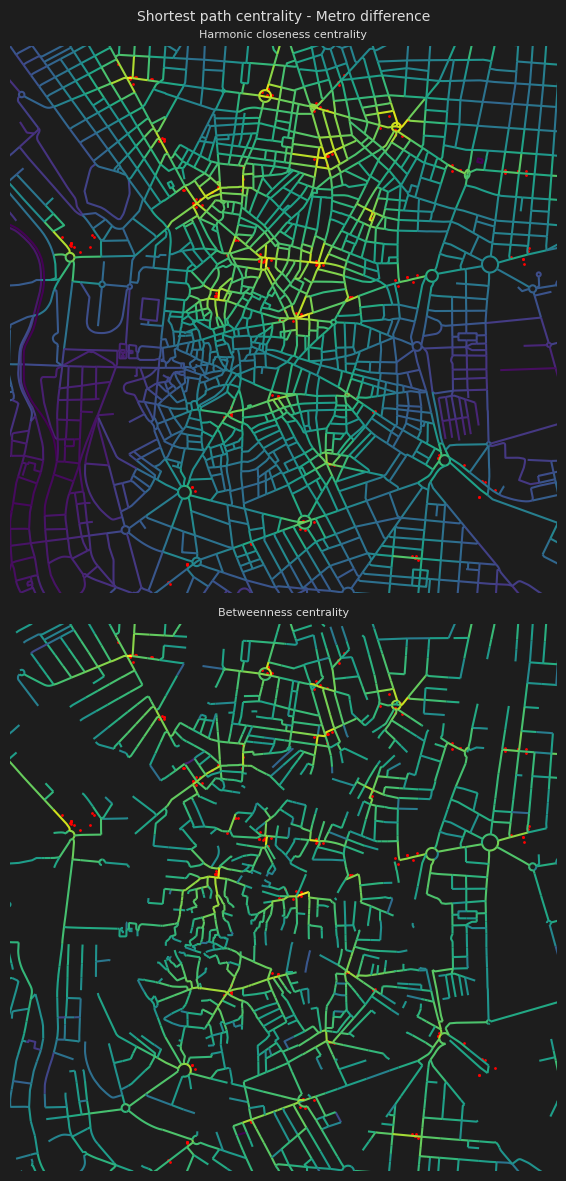

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(8, 12), facecolor="#1d1d1d")
fig.suptitle(
    "Shortest path centrality - Metro difference",
    fontsize=10,
    color="#ddd",
)

nodes_gdf.plot(
    column="cc_harmonic_2000_diff",
    cmap="viridis",
    legend=False,
    ax=axes[0],
)
axes[0].set_title(
    "Harmonic closeness centrality",
    fontsize=8,
    color="#ddd",
)
stops_gdf.plot(ax=axes[0], color="red", markersize=1)

nodes_gdf.plot(
    column="cc_betweenness_2000_diff",
    cmap="viridis",
    norm=colors.LogNorm(),  # Apply log normalization
    legend=False,
    ax=axes[1],
)
axes[1].set_title(
    "Betweenness centrality",
    fontsize=8,
    color="#ddd",
)
stops_gdf.plot(ax=axes[1], color="red", markersize=1)

for ax in axes:
    ax.set_xlim(438500, 438500 + 3500)
    ax.set_ylim(4472500, 4472500 + 3500)
    ax.axis(False)

plt.tight_layout()